# Reinforcement Learning with Human Feedback with [Argilla](https://docs.argilla.io/en/latest/tutorials/notebooks/labelling-spacy-llm.html#FeedbackDataset) :

## Creating a comparison Dataset

The notebook will help set up workflows for collecting comparison data to train a reward model. RLHF involves training a reward model to rate responses in alignment with human preferances. Subsquently, the LLM is finetuning using Reinforcement learning to generate high scoring responses as per the reward model. While the reward model scores prompt-response pair, comparison dataset is generally gathered differently. This typically involves humans ranking several responses to a particular prompt from best to worst. 

In this notebook we :

- create the dataset
- add annotators to give feedback

### Import packages

In [2]:
import os
import pandas as pd
from datasets import load_dataset
import argilla as rg
from dotenv import load_dotenv

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

In [3]:
load_dotenv()

True

In [ ]:
rg.init(
    api_url=os.environ.get("ARGILLA_API_URL"),
    api_key=os.environ.get("ARGILLA_API_KEY"),
)

## Create the dataset

In [85]:
dataset = rg.FeedbackDataset(
    guidelines="Please, read the question carefully and try to answer it as accurately as possible.",
    fields=[
        rg.TextField(name="prompt", required=True),
        rg.TextField(name="response-1", required=True)
    ],
    questions=[
        rg.TextQuestion(
            name="question",
            title="Are there any missing candidate documents that contain the answer to the query?",
            required=True,
        ),
        rg.RatingQuestion(
            name="preferred_response_quality",
            description="Rate the response's correctness and helpfulness, with 1 indicating it's completely useless/incorrect, and 5 meaning it's entirely helpful/correct.",
            values=[1, 2, 3, 4, 5],
            required=True,
        ),
        rg.TextQuestion(
            name="correct_response",
            title="What should be the exact response of the query? Please modify or recreate the generated answer:",
            required=True,
        ),
        rg.TextQuestion(
            name="additional_info",
            title="Are there any additional comments or suggestions for the application?",
            required=False,
        )
    ]
)

## Taking a sample model to create a prompt response pair for feedback dataset

In [86]:
# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained("vicgalle/gpt2-open-instruct-v1")
tokenizer = AutoTokenizer.from_pretrained("vicgalle/gpt2-open-instruct-v1")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [87]:
# Create a pipeline for text generation
gen_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

In [88]:
# Define prompts (you can replace these with your actual prompts)
prompts = ['Where can I see a roadmap or make feature requests for the service?',
           'How is the pricing of Red Hat OpenShift Service on AWS calculated?',
           'Is there an upfront commitment?',
           'How can I delete ROSA cluster?',
           'Can I shut down my VMs temporarily?',
           'How can I automatically deploy ROSA cluster?',
           'How can my ROSA cluster autoscale?',
           'How can I install aws load balancer controller',
           'How can I install Prometheus Operator with my ROSA cluster?',
           'What time is it?', 
           'How can I federate metrics to a centralized Prometheus Cluster?',
           'What is the meaning of life?']

In [89]:
records = []
for prompt in prompts:  # Iterate directly over the prompts
    # Generate two responses in one call
    outputs = gen_pipeline(
        prompt,
        max_length=100,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
    )
    responses = [output["generated_text"] for output in outputs]

    record = rg.FeedbackRecord(
        fields={"prompt": prompt, "response-1": responses[0]}
    )
    records.append(record)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Adding the prompt response pair to feedback dataset

In [90]:
# Add records to the dataset
dataset.add_records(records)

In [91]:
dataset

<FeedbackDataset fields=[TextField(id=None, name='prompt', title='Prompt', required=True, type='text', settings={'type': 'text', 'use_markdown': False}, use_markdown=False), TextField(id=None, name='response-1', title='Response-1', required=True, type='text', settings={'type': 'text', 'use_markdown': False}, use_markdown=False)] questions=[TextQuestion(id=None, name='question', title='Are there any missing candidate documents that contain the answer the query?', description=None, required=True, type='text', settings={'type': 'text', 'use_markdown': False}, use_markdown=False), RatingQuestion(id=None, name='preferred_response_quality', title='Preferred_response_quality', description="Rate the response's correctness and helpfulness, with 1 indicating it's completely useless/incorrect, and 5 meaning it's entirely helpful/correct.", required=True, type='rating', settings={'type': 'rating', 'options': [{'value': 1}, {'value': 2}, {'value': 3}, {'value': 4}, {'value': 5}]}, values=[1, 2, 3, 

In [92]:
rg.Workspace.create("feedback-test9")

Workspace(id=1ee704ee-86b4-4324-899f-32bea45fe1d2, name=feedback-test9, inserted_at=2023-10-10 14:27:38.691082, updated_at=2023-10-10 14:27:38.691082)

In [93]:
workspaces = rg.Workspace.list()

In [94]:
for workspace in workspaces:
    print(workspace)

Workspace(id=e30eb6f7-6461-43a7-916d-e69c36807bea, name=argilla, inserted_at=2023-08-24 22:53:29.608650, updated_at=2023-08-24 22:53:29.608650)
Workspace(id=eea05e17-b338-4ecc-a941-214b3c6b5db6, name=feedback-test, inserted_at=2023-08-28 01:25:52.197108, updated_at=2023-08-28 01:25:52.197108)
Workspace(id=707e4a71-52c0-45a1-952f-90994806266a, name=feedback-demo, inserted_at=2023-09-19 12:31:28.221687, updated_at=2023-09-19 12:31:28.221687)
Workspace(id=c090c971-0d7e-4b66-8fdd-843acdf7c5dc, name=feedback-test1, inserted_at=2023-10-09 00:45:53.553912, updated_at=2023-10-09 00:45:53.553912)
Workspace(id=229c8a47-b71c-4532-a3e8-5dfe36c27c8f, name=feedback-test2, inserted_at=2023-10-09 01:08:04.294778, updated_at=2023-10-09 01:08:04.294778)
Workspace(id=c61ca9c7-cab1-4887-8ae6-26eff4677532, name=feedback-test3, inserted_at=2023-10-09 12:02:30.869460, updated_at=2023-10-09 12:02:30.869460)
Workspace(id=8d8947f3-b564-45df-bff1-db5b7a6c24e0, name=feedback-test4, inserted_at=2023-10-09 15:23:03

In [95]:
remote_dataset = dataset.push_to_argilla(name="response-rank-test", workspace="feedback-test9")

Pushing records to Argilla...: 100%|██████████| 1/1 [00:00<00:00, 29.49it/s]


## Adding annotators

Lets check different users:

In [69]:
users = rg.User.list()

In [70]:
for user in users:
    print(user)

User(id=71f679d9-5f04-41da-8e75-b142387853e8, username=argilla, role=owner, api_key=argilla.apikey, first_name=, last_name=None, inserted_at=2023-08-24 22:53:29.608650, updated_at=2023-08-24 22:53:29.608650)
User(id=268b81d3-d059-4ae4-9f61-17ec712ac954, username=suppathak, role=annotator, api_key=hV5oK929ypHBRDho7JoMjKgykxuiVXZij3klZgA--OCkWvBvSC_catD-2owSXUaJlPOsmAI6AYRtmX1vzToM3x4yIBiakIsYM_AyomESFZM, first_name=Surya, last_name=Pathak, inserted_at=2023-10-09 05:23:22.717569, updated_at=2023-10-09 05:23:22.717569)
User(id=2632f67a-d5b6-42c5-8f66-73096fd4ec1d, username=test-annotator, role=annotator, api_key=2-rMEz2pvxTBk4IYCsVlP52CrOy6R9gsmtB2FDwCMIh6BLuxQrrtbep4S0qbRv11gxIRVAuXjnLV-rUfFwoBM2dYfBjDman7Cvc5JoM0qe8, first_name=user, last_name=annotator, inserted_at=2023-10-09 12:06:11.554667, updated_at=2023-10-09 12:06:11.554667)
User(id=b887f3d0-7672-4dcf-81d6-541ab623f5d5, username=test-annotator2, role=annotator, api_key=7GuA7n92pFx-fA3uikXVBsQ2N7Pul6gglwEBt1vRDLLJ6GbtQvyHdzCBlS7oM

The current list suggest there are currently two users, one is the owner and another is the annotator. 

If we want to add a user as an annotator for a particular workspace. Here is an example.

In [ ]:
user = rg.User.create(
    username="test-annotator2",
    first_name="user",
    last_name="annotator",
    password="12345678",
    role="annotator",
    workspaces=["feedback-test3"]
)

The annotator can login argilla workspace using this link, `http://argilla-test-route-argilla-test.apps.et-cluster.6mwp.p1.openshiftapps.com/datasets` , and using the username = `test-annotator` and password = `12345678`, defined above. The user will have access to the workspace, `feedback-3`. 

Lets check now, how many users are there as an annotator.

In [ ]:
users = [u for u in rg.User.list() if u.role == "annotator"]

In [ ]:
users

## Collect feedback dataset [Ref](https://docs.argilla.io/en/latest/practical_guides/collect_responses.html)

In [71]:
feedback = rg.FeedbackDataset.from_argilla("response-rank-test", workspace="feedback-test8")

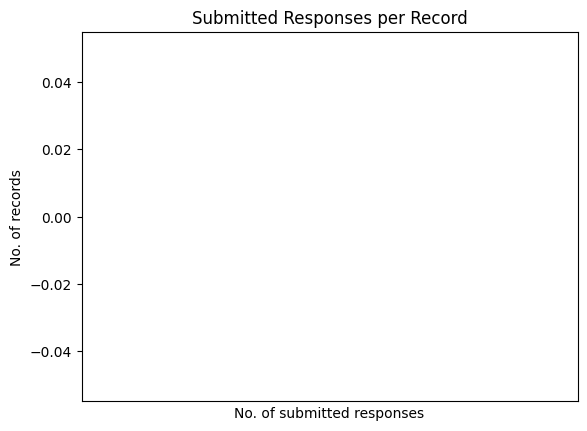

In [72]:
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict

count_submitted = Counter()
for record in feedback.records:
    if record.responses:
        submitted = [r for r in record.responses if r.status == "submitted"]
        count_submitted[len(submitted)] += 1

# Sort the counts by the number of submitted responses
count_submitted = OrderedDict(sorted(count_submitted.items()))

submitted_responses = list(count_submitted.keys())
no_records = list(count_submitted.values())

plt.bar(submitted_responses, no_records)
plt.xlabel("No. of submitted responses")
plt.ylabel("No. of records")
plt.title("Submitted Responses per Record")
plt.xticks(submitted_responses)
plt.show()

The above plot shows two annotators and the number of response they have submitted.

## Export feedback dataset

In [73]:
dataset = rg.FeedbackDataset.from_argilla("response-rank-test", workspace="feedback-test8")

In [74]:
dataset

<FeedbackDataset id=39683f5e-7d52-48aa-9da1-bd319cb670f1 name=response-rank-test workspace=Workspace(id=d9644f96-51ca-4a71-9f68-72602a652008, name=feedback-test8, inserted_at=2023-10-09 17:55:45.525929, updated_at=2023-10-09 17:55:45.525929) url=http://argilla-test-route-argilla-test.apps.et-cluster.6mwp.p1.openshiftapps.com/dataset/39683f5e-7d52-48aa-9da1-bd319cb670f1/annotation-mode fields=[TextField(id=UUID('74dda634-2f6a-47d6-a96d-99f6c8413444'), name='prompt', title='Prompt', required=True, type='text', settings={'type': 'text', 'use_markdown': False}, use_markdown=False), TextField(id=UUID('2d460608-f1e0-4e33-a68f-6171f72a9077'), name='response-1', title='Response-1', required=True, type='text', settings={'type': 'text', 'use_markdown': False}, use_markdown=False)] questions=[TextQuestion(id=UUID('e6172dd8-9702-4520-83a9-cfc6aaa71030'), name='question', title='Are there any document that answer the query but are not there in candidate document?', description=None, required=True, 

In [75]:
df_dataset = dataset.format_as("datasets")

In [76]:
df_dataset.to_csv("feedback.csv")  # Save as CSV

Creating CSV from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 84.59ba/s]


7533

In [77]:
df = pd.read_csv('feedback.csv')

In [78]:
len(df)

12

In [79]:
df.head()

,prompt,response-1,question,question-suggestion,question-suggestion-metadata,preferred_response_quality,preferred_response_quality-suggestion,preferred_response_quality-suggestion-metadata,correct_response,correct_response-suggestion,correct_response-suggestion-metadata,external_id,metadata
0,What is the meaning of life?,What is the meaning of life? It is a question ...,[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",NaN,{}
1,How can my ROSA cluster autoscale?,How can my ROSA cluster autoscale?\n\n\nHere a...,[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",NaN,{}
2,How can I install Prometheus Operator with my ...,How can I install Prometheus Operator with my ...,[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",NaN,{}
3,Is there an upfront commitment?,Is there an upfront commitment?\n\nWhat does t...,[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",NaN,{}
4,How can I federate metrics to a centralized Pr...,How can I federate metrics to a centralized Pr...,[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",[],NaN,"{'type': None, 'score': None, 'agent': None}",NaN,{}
